Epoch 1/20
258/258 [==============================] - 142s 526ms/step - loss: 0.1031 - accuracy: 0.4327 - val_loss: 0.0287 - val_accuracy: 0.5188
Epoch 2/20
258/258 [==============================] - 126s 487ms/step - loss: 0.0290 - accuracy: 0.4175 - val_loss: 0.0270 - val_accuracy: 0.5188
Epoch 3/20
258/258 [==============================] - 122s 474ms/step - loss: 0.0281 - accuracy: 0.4520 - val_loss: 0.0266 - val_accuracy: 0.5188
Epoch 4/20
258/258 [==============================] - 122s 473ms/step - loss: 0.0279 - accuracy: 0.4748 - val_loss: 0.0265 - val_accuracy: 0.5188
Epoch 5/20
258/258 [==============================] - 122s 471ms/step - loss: 0.0278 - accuracy: 0.4496 - val_loss: 0.0264 - val_accuracy: 0.5188
Epoch 6/20
258/258 [==============================] - 122s 471ms/step - loss: 0.0278 - accuracy: 0.4455 - val_loss: 0.0264 - val_accuracy: 0.2690
Epoch 7/20
258/258 [==============================] - 123s 476ms/step - loss: 0.0278 - accuracy: 0.4423 - val_loss: 0.0263 -

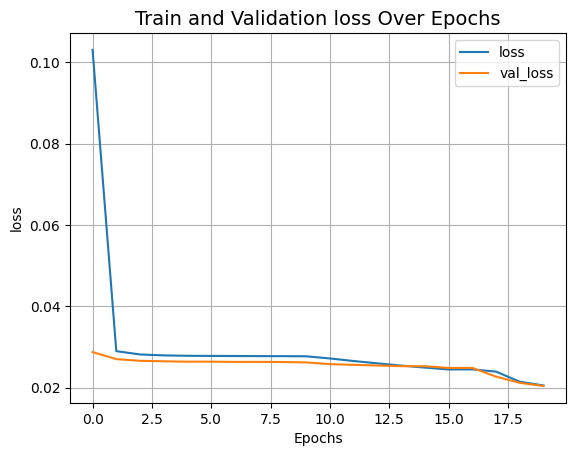

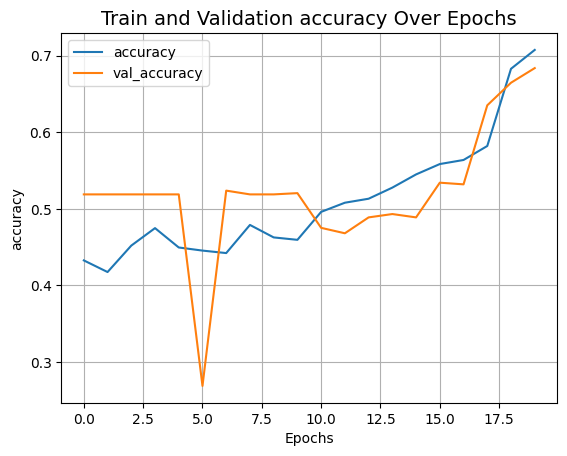

58/58 [==============================] - 3s 43ms/step - loss: 0.0217 - accuracy: 0.6912
Accuracy on the test set: 69.12%.


In [ ]:
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Dense, LSTM, Embedding, SpatialDropout1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ast import literal_eval

# Load the dataset
arxiv_data = pd.read_csv("/content/drive/MyDrive/IML-Recommender-Paper/arxiv_data.csv")

# Remove duplicate titles
arxiv_data = arxiv_data[~arxiv_data["titles"].duplicated()]

# Filter out rare terms
arxiv_data_filtered = arxiv_data.groupby("terms").filter(lambda x: len(x) > 1)

# Convert string representation of lists to actual lists
arxiv_data_filtered["terms"] = arxiv_data_filtered["terms"].apply(lambda x: literal_eval(x))

test_split = 0.1

# Initial train and test split
train_df, test_df = train_test_split(
    arxiv_data_filtered,
    test_size=test_split,
    stratify=arxiv_data_filtered["terms"].values
)

# Further split the test set into validation and new test sets
val_df = test_df.sample(frac=0.5)
test_df.drop(val_df.index, inplace=True)

# Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_df["summaries"])
vocab_size = len(tokenizer.word_index) + 1

# Maximum sequence length
maxlen = 150

# Convert text data to sequences
train_sequences = tokenizer.texts_to_sequences(train_df["summaries"])
val_sequences = tokenizer.texts_to_sequences(val_df["summaries"])
test_sequences = tokenizer.texts_to_sequences(test_df["summaries"])

# Pad sequences
train_padded = pad_sequences(train_sequences, maxlen=maxlen, padding="post")
val_padded = pad_sequences(val_sequences, maxlen=maxlen, padding="post")
test_padded = pad_sequences(test_sequences, maxlen=maxlen, padding="post")

# Multi-label binarization
mlb = MultiLabelBinarizer()
mlb.fit(train_df["terms"])
train_labels = mlb.transform(train_df["terms"])
val_labels = mlb.transform(val_df["terms"])
test_labels = mlb.transform(test_df["terms"])

# Define LSTM model
def make_lstm_model(vocabulary_size, embedding_dim, lstm_units, num_classes):
    model = models.Sequential([
        Embedding(input_dim=vocabulary_size, output_dim=embedding_dim, input_length=maxlen),
        SpatialDropout1D(0.2),
        LSTM(units=lstm_units, dropout=0.2, recurrent_dropout=0.2),
        Dense(num_classes, activation='sigmoid')
    ])
    return model

# Hyperparameters
embedding_dim = 128
lstm_units = 64
epochs = 20
batch_size = 128

# Create LSTM model
lstm_model = make_lstm_model(
    vocabulary_size=vocab_size,
    embedding_dim=embedding_dim,
    lstm_units=lstm_units,
    num_classes=len(mlb.classes_)
)

# Compile LSTM model
lstm_model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

# Train LSTM model
lstm_history = lstm_model.fit(train_padded, train_labels,
                              validation_data=(val_padded, val_labels),
                              epochs=epochs, batch_size=batch_size, verbose=1)

# Plot LSTM model performance
def plot_result(item, history):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()

plot_result("loss", lstm_history)
plot_result("accuracy", lstm_history)

# Evaluate LSTM model on test data
test_loss, test_accuracy = lstm_model.evaluate(test_padded, test_labels, verbose=1)
print(f"Accuracy on the test set: {test_accuracy * 100:.2f}%.")


In [ ]:
import random

# Set a random seed for reproducibility
random.seed(42)

# Function to preprocess input text
def preprocess_text(text):
    # Tokenize the text
    sequence = tokenizer.texts_to_sequences([text])
    # Pad sequence
    padded_sequence = pad_sequences(sequence, maxlen=maxlen, padding="post")
    return padded_sequence

# Function to get predicted labels
def get_predicted_labels(model, text):
    # Preprocess input text
    preprocessed_text = preprocess_text(text)
    # Make predictions
    predictions = model.predict(preprocessed_text)
    # Get top predicted labels
    top_labels_indices = np.argsort(predictions[0])[::-1][:3]  # Top 3 labels
    top_labels = mlb.classes_[top_labels_indices]
    return top_labels

# Function to print random data with true and predicted labels
def print_random_data(model, text_data, label_data, mlb, num_samples=5):
    # Randomly select five indices
    sample_indices = random.sample(range(len(text_data)), num_samples)
    for idx in sample_indices:
        text = text_data.iloc[idx]
        true_labels = mlb.inverse_transform(label_data[idx].reshape(1, -1))[0]
        predicted_labels = get_predicted_labels(model, text)
        print("True Labels:", true_labels)
        print("Predicted Labels:", predicted_labels)
        print()

# Print random data with true and predicted labels for five samples
print_random_data(lstm_model, test_df["summaries"], test_labels, mlb)


1/1 [==============================] - 0s 93ms/step
True Labels: ('cs.CV', 'cs.LG')
Predicted Labels: ['cs.CV' 'cs.LG' 'cs.AI']

1/1 [==============================] - 0s 94ms/step
True Labels: ('cs.CV',)
Predicted Labels: ['cs.CV' 'cs.LG' 'cs.AI']

1/1 [==============================] - 0s 110ms/step
True Labels: ('cs.LG', 'math.ST', 'stat.ML', 'stat.TH')
Predicted Labels: ['cs.LG' 'stat.ML' 'cs.AI']

1/1 [==============================] - 0s 96ms/step
True Labels: ('cs.CV',)
Predicted Labels: ['cs.CV' 'cs.LG' 'eess.IV']

1/1 [==============================] - 0s 99ms/step
True Labels: ('cs.LG', 'math.PR', 'stat.ML')
Predicted Labels: ['cs.LG' 'stat.ML' 'cs.AI']

